# Mews SRE Task

## Initial exploration

In [3]:
# Some imports for the future
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,3) # so we get some nice wide plots
import numpy as np

First, let's start looking at how the data is structured.

In [4]:
logs = pd.read_json("./logs.txt", lines=True)

logs.head()

,TimeStamp,Endpoint,StatusCode,Duration
0,2021-08-26 13:00:00.000,/api/reservations/add,200,471
1,2021-08-26 13:00:00.064,/api/reservations/add,200,511
2,2021-08-26 13:00:00.115,/api/reservations/add,200,523
3,2021-08-26 13:00:00.258,/api/reservations/add,200,537
4,2021-08-26 13:00:00.349,/api/reservations/add,200,485


Let's verify that all the data has been cast to the right format automatically

In [5]:
logs.dtypes

TimeStamp     datetime64[ns]
Endpoint              object
StatusCode             int64
Duration               int64
dtype: object

Looks good.

Let's take a look at all the endpoints in the logs, just to get an overview of what we are dealing with.

In [6]:
logs["Endpoint"].unique()

array(['/api/reservations/add', '/api/reservations/get',
       '/api/reservations/cancel', '/api/reservations/update',
       '/api/rates/add', '/api/rates/update', '/api/rates/delete'],
      dtype=object)

Also, as an overview, let's look if we have any endpoint returning anything that is not 200.

In [7]:
logs[logs["StatusCode"] != 200]

,TimeStamp,Endpoint,StatusCode,Duration


All the logs return a status code of 200, the system was always operational.

## Looking at the endpoints

Since the task mentions that at some point for some endpoints, response time might be impacted, let's see if we can visually identify endpoints which had slowdowns, just by looking at a plot which for each event, plots the duration. 

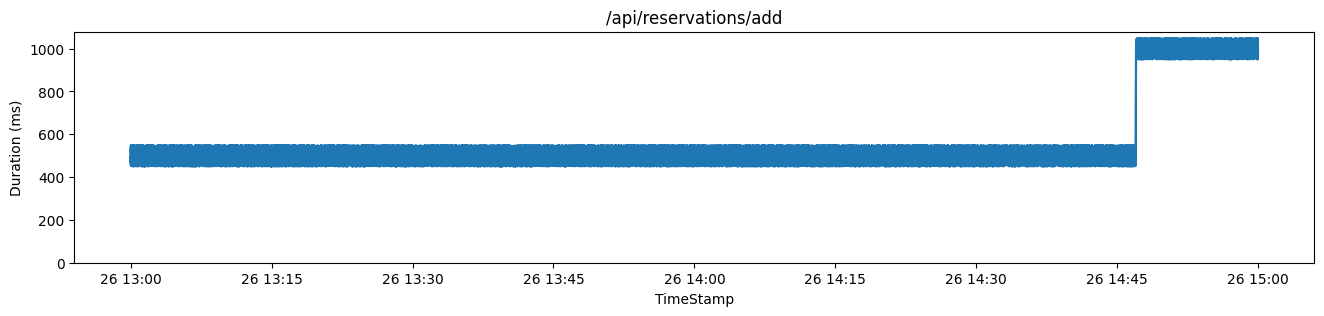

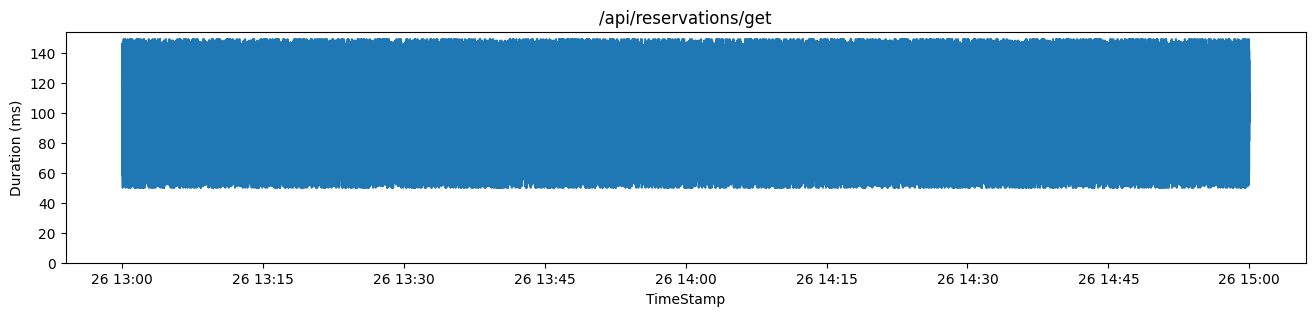

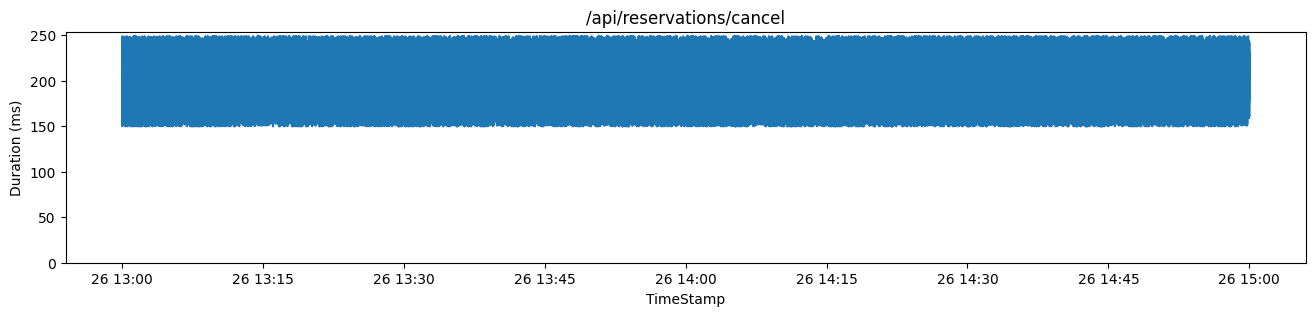

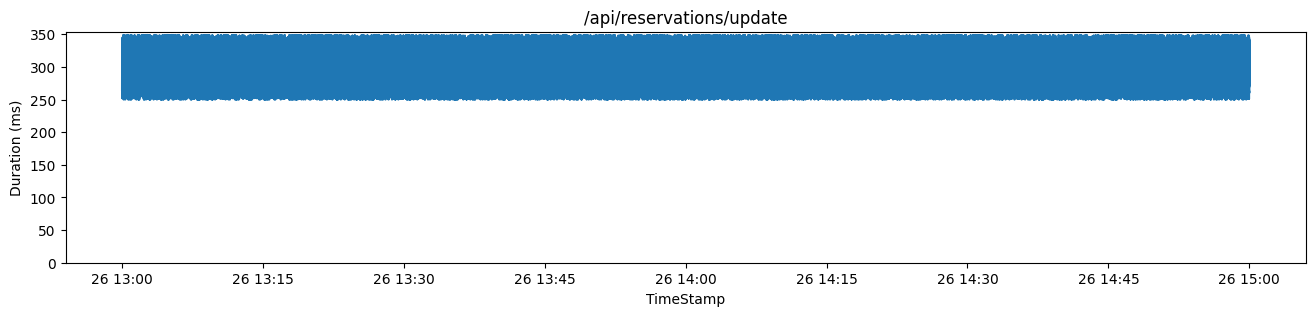

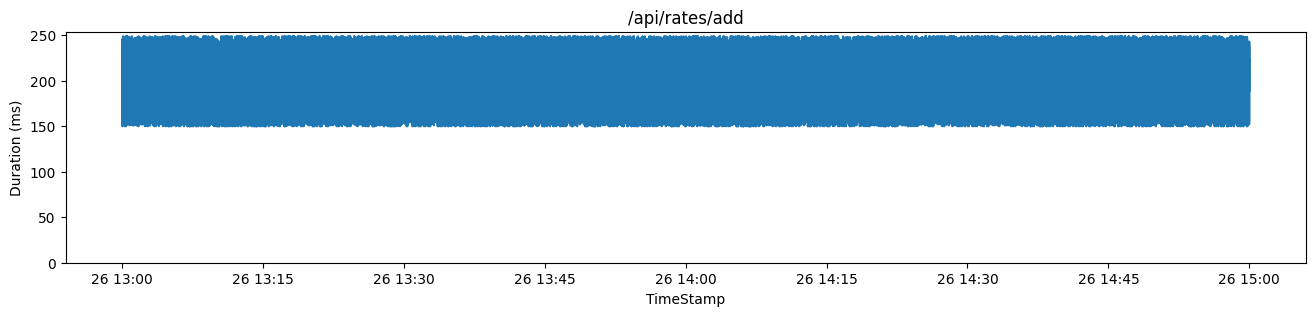

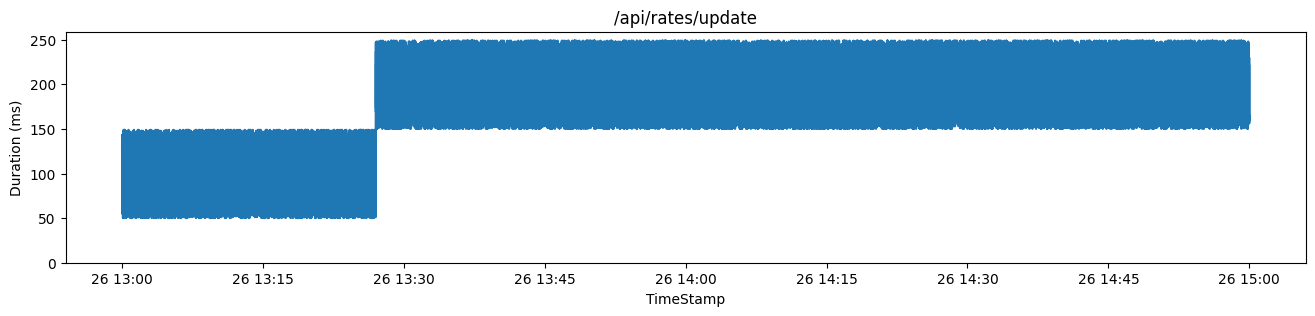

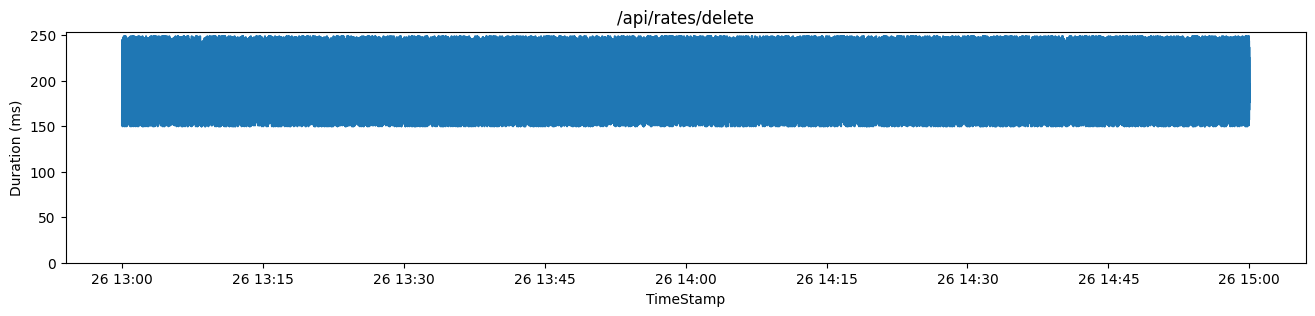

In [8]:
for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint]
    plt.plot(endpoint_logs["TimeStamp"], endpoint_logs["Duration"])
    plt.title(endpoint)
    plt.xlabel("TimeStamp")
    plt.ylabel("Duration (ms)")
    plt.ylim(ymin=0) # so we have 0ms as a baseline for the plot
    plt.show()

The plots are a bit noisy, there are a lot of data points to consider. But still we can visually identify a slowdown for the endpoints `/api/reservations/add` and `/api/rates/updates` at some point in the time series.

All the other endpoints appear to be fine, at least visually, with some sistematic fluctuations that are observable. 

Clarity of the plots could be improved by reducing the data points, by averaging/bucketing timestamps close to each other (for example by averaging out requests in buckets of 5 minutes). I am not doing this since it is not particularly useful now. 

## The definition of "regression"

Since we are working with very loose specifications on the definition of regression (slowdown), we can think a bit on which meaning we want to give to this word.

### Maximum duration

One possible definition of "slowdown" would be one that checks based on some endpoint duration "budget". It is possible that, in some use cases, each endpoint must respond within a certain timeframe/must have a maximum latency, otherwise the service can be considered distrupted. For example one can have an agreement that speecifies "all endpoints must give an answer in maximum 1s". If that was the case, it would mean that finding regressing endpoints (and when they started regressing) would be quite trivial, as follows:

In [16]:
MAXIMUM_DURATION = 1000 # ms
logs[logs["Duration"] > MAXIMUM_DURATION].groupby("Endpoint").first() # selects the first log that regresses for each endpoint

,TimeStamp,StatusCode,Duration
Endpoint,,,
/api/reservations/add,2021-08-26 14:47:00.248,200,1011


We can see that the only endpoint that "regresses" given our definition of "answer in maximum 1 second" is just `/api/reservations/add`, which regresses at `2021-08-26 14:47:00.248`. 

By having different `MAXIMUM_DURATION` per endpoint, we can adapt to the fact that endpoints might have different latency "budgets". 

In [60]:
MAXIMUM_DURATIONS = {
    "/api/reservations/add": 1000,
    "/api/rates/update": 200,
}

for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint]
    TARGET_DURATION = MAXIMUM_DURATIONS.get(endpoint, 1000) # if a value is not set for this particular endpoint, use 1s
    slow_endpoint_logs = endpoint_logs[endpoint_logs["Duration"] > TARGET_DURATION] # get all log lones which are over the TARGET_DURATION
    if len(slow_endpoint_logs) > 1:
        print(f"{endpoint}: {len(slow_endpoint_logs)} requests went over the target of {TARGET_DURATION}ms")
        print(f"{endpoint}: first regressing request: {slow_endpoint_logs.iloc[0]['TimeStamp']}")
        print("")        

/api/reservations/add: 3166 requests went over the target of 1000ms
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.248000

/api/rates/update: 21956 requests went over the target of 200ms
/api/rates/update: first regressing request: 2021-08-26 13:27:00.309000



Of course this logic is not always applicable for all business use cases. 
If you have no business-specified maximum endpoint response time, you could try to set an arbitrarly high maximum duration, but slowdown not considered "high enough" would be missed and service could still be impacted.

### Adaptive solution

We can also write a solution which is not based on arbitrary numbers, but which adapts to each endpoint automatically, as new data comes in. 

The intuition is simple, if we see an endpoint "misbehaving" from the "usual", then it must be regressing. But how do we define this "usual" and this "misbehaving"?  

If we imagine this analysis to happen "online", as the logs are coming, we might be able to keep an average measure of the latency for each endpoint, computed over the logs we have seen so far. 

As each new log arrives to our monitoring system, we compare this log duration with the "expected" value, the average latency we have seen so far. If the log duration is "greatly different" from this expected result, then the endpoint must be misbehaving.

To measure the "greatly different" we could make use of something like standard deviation, which tells us the general "variation" in duration for a certain endpoint, calculated over the logs we have seen so far. Only after taking the decision, we will update the average we have seen so far.

Basically to identify if a log is misbehaving we want to check if `log["Duration"] > (average_log_duration_we_have_seen_so_far + stdev_log_duration_we_have_seen_so_far * K)`, where K defines on how "flexible" we are with endpoints misbehaving.

As an example, here we compute what I just mentioned for the endpoint `/api/reservations/add`. As you can see the first rows have no average or stdev, because we have yet to compute it.

In [49]:
logs_for_some_endpoint = logs[logs["Endpoint"] == "/api/reservations/add"].copy()
logs_for_some_endpoint["AverageDurationSoFar"] = logs_for_some_endpoint["Duration"].expanding().mean().shift(1)
logs_for_some_endpoint["StdevDurationSoFar"] = logs_for_some_endpoint["Duration"].expanding().std().shift(1)
logs_for_some_endpoint

,TimeStamp,Endpoint,StatusCode,Duration,AverageDurationSoFar,StdevDurationSoFar
0,2021-08-26 13:00:00.000,/api/reservations/add,200,471,NaN,NaN
1,2021-08-26 13:00:00.064,/api/reservations/add,200,511,471.000000,NaN
2,2021-08-26 13:00:00.115,/api/reservations/add,200,523,491.000000,28.284271
3,2021-08-26 13:00:00.258,/api/reservations/add,200,537,501.666667,27.227437
4,2021-08-26 13:00:00.349,/api/reservations/add,200,485,510.500000,28.396009
...,...,...,...,...,...,...
58018,2021-08-26 14:59:59.413,/api/reservations/add,200,957,553.995691,158.608293
58019,2021-08-26 14:59:59.526,/api/reservations/add,200,995,554.002637,158.615750
58020,2021-08-26 14:59:59.705,/api/reservations/add,200,1041,554.010238,158.624949
58021,2021-08-26 14:59:59.797,/api/reservations/add,200,957,554.018631,158.636466


We can actually see that the Stedv is much higher for the latest logs, and so is the average. Infact we can plot both to visualize this:

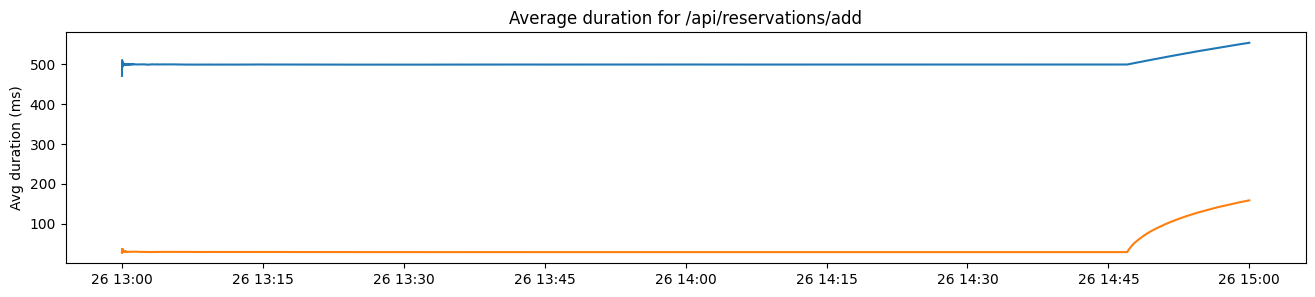

In [55]:
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["AverageDurationSoFar"])
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["StdevDurationSoFar"])
plt.title("Average duration for /api/reservations/add")
plt.ylabel("Avg duration (ms)")
plt.show()

We can easily see the average and the stdev growing when a regression is hit. 

Now, we can actually use these findings to find the first regression for each endpoint, by computing the same values over each endpoint.

In [61]:
K = 2
for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint].copy()
    endpoint_logs["AverageDurationSoFar"] = endpoint_logs["Duration"].expanding().mean().shift(1)
    endpoint_logs["StdevDurationSoFar"] = endpoint_logs["Duration"].expanding().std().shift(1)
    regressing_logs = endpoint_logs[endpoint_logs["Duration"] > endpoint_logs["AverageDurationSoFar"] + endpoint_logs["StdevDurationSoFar"] * K]
    if len(regressing_logs) > 1:
        print(f"{endpoint}: {len(regressing_logs)} found to be regressing")
        print(f"{endpoint}: first regressing request: {regressing_logs.iloc[0]['TimeStamp']}")
        print("")

/api/reservations/add: 6325 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/reservations/update: 2 found to be regressing
/api/reservations/update: first regressing request: 2021-08-26 13:00:00.269000

/api/rates/update: 2459 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:00:07.135000

/api/rates/delete: 3 found to be regressing
/api/rates/delete: first regressing request: 2021-08-26 13:00:00.221000



As we can see some innocent logs were identified as regressing, because we need to give the alghoritm some time to learn and compute some "expected" values for average and stdev. We can do this easily by not analyzing the first N requests for each endpoint, with N being a "not very small" number. Let's adapt the code above with this.  

In [69]:
K = 2
N = 10
for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint].copy()
    endpoint_logs["AverageDurationSoFar"] = endpoint_logs["Duration"].expanding().mean().shift(1)
    endpoint_logs["StdevDurationSoFar"] = endpoint_logs["Duration"].expanding().std().shift(1)
    endpoint_logs = endpoint_logs.iloc[N:] # drop the first N rows
    regressing_logs = endpoint_logs[endpoint_logs["Duration"] > endpoint_logs["AverageDurationSoFar"] + endpoint_logs["StdevDurationSoFar"] * K]
    if len(regressing_logs) > 1:
        print(f"{endpoint}: {len(regressing_logs)} found to be regressing")
        print(f"{endpoint}: first regressing request: {regressing_logs.iloc[0]['TimeStamp']}")
        print("")

/api/reservations/add: 6325 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/rates/update: 2459 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:00:07.135000



Let's put this code into a function, which we can re-use as needed.

In [70]:
def slow_endpoints(K, N):
    for endpoint in logs["Endpoint"].unique():
        endpoint_logs = logs[logs["Endpoint"] == endpoint].copy()
        endpoint_logs["AverageDurationSoFar"] = endpoint_logs["Duration"].expanding().mean().shift(1)
        endpoint_logs["StdevDurationSoFar"] = endpoint_logs["Duration"].expanding().std().shift(1)
        endpoint_logs = endpoint_logs.iloc[N:] # drop the first N rows
        regressing_logs = endpoint_logs[endpoint_logs["Duration"] > endpoint_logs["AverageDurationSoFar"] + endpoint_logs["StdevDurationSoFar"] * K]
        if len(regressing_logs) > 1:
            print(f"{endpoint}: {len(regressing_logs)} found to be regressing")
            print(f"{endpoint}: first regressing request: {regressing_logs.iloc[0]['TimeStamp']}")
            print("")

We can see that we get different results depending on higher or lower K (less or more flexibility) or N (more time to adapt)

In [74]:
slow_endpoints(K=2, N=10)

/api/reservations/add: 6325 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/rates/update: 2459 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:00:07.135000



In [75]:
slow_endpoints(K=2, N=100)

/api/reservations/add: 6325 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/rates/update: 2457 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:27:00.309000



In [76]:
slow_endpoints(K=3, N=100)

/api/reservations/add: 5493 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/rates/update: 559 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:27:00.309000



One thing to notice is that, with this solution, the `average_so_far` and `stdev_so_far` update very slowly, so the alghoritm might be quite slow to respond in regards to changes in duration time. This can be seen in the plot below which plots the duration for `/api/reservations/add` and "danger level"

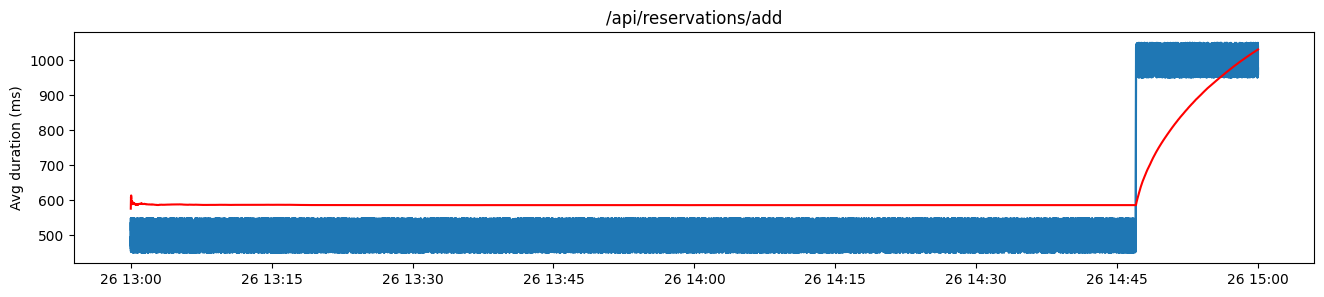

In [83]:
K = 3
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["Duration"])
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["AverageDurationSoFar"] + logs_for_some_endpoint["StdevDurationSoFar"] * K, color="red")
plt.title("/api/reservations/add")
plt.ylabel("Avg duration (ms)")
plt.show()

We can adapt this solution to be more responsive by windowing/rolling the average and stdev computation: instead of calculating it over all the logs, we calculate it over the last W logs. Depending on the implementation the first W logs won't be useful, because the average and stdev won't be calculated. As shown below:

In [91]:
W = 100
logs_for_some_endpoint = logs[logs["Endpoint"] == "/api/reservations/add"].copy()
logs_for_some_endpoint["AverageDurationWindow"] = logs_for_some_endpoint["Duration"].rolling(W).mean().shift(1)
logs_for_some_endpoint["StdevDurationWindow"] = logs_for_some_endpoint["Duration"].rolling(W).std().shift(1)
logs_for_some_endpoint

,TimeStamp,Endpoint,StatusCode,Duration,AverageDurationWindow,StdevDurationWindow
0,2021-08-26 13:00:00.000,/api/reservations/add,200,471,NaN,NaN
1,2021-08-26 13:00:00.064,/api/reservations/add,200,511,NaN,NaN
2,2021-08-26 13:00:00.115,/api/reservations/add,200,523,NaN,NaN
3,2021-08-26 13:00:00.258,/api/reservations/add,200,537,NaN,NaN
4,2021-08-26 13:00:00.349,/api/reservations/add,200,485,NaN,NaN
...,...,...,...,...,...,...
58018,2021-08-26 14:59:59.413,/api/reservations/add,200,957,1002.11,30.956436
58019,2021-08-26 14:59:59.526,/api/reservations/add,200,995,1001.23,30.975668
58020,2021-08-26 14:59:59.705,/api/reservations/add,200,1041,1001.42,30.877464
58021,2021-08-26 14:59:59.797,/api/reservations/add,200,957,1002.01,31.065748


Let's visualize the "danger level" now. It adapts much more quickly

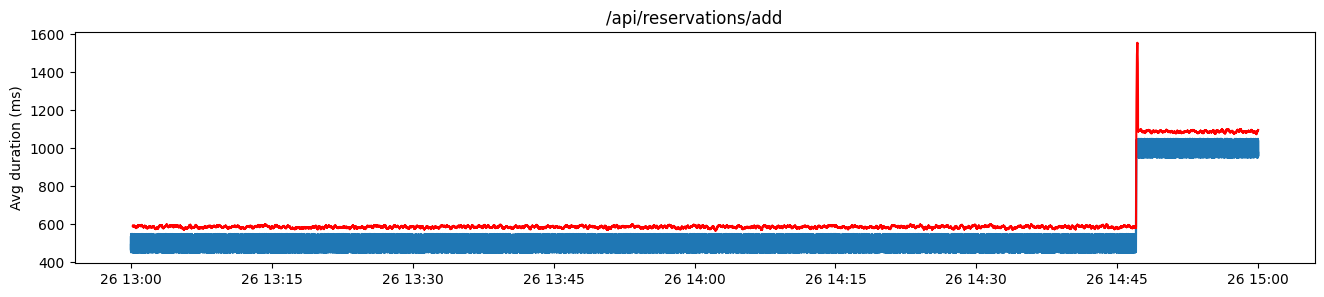

In [92]:
K = 3
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["Duration"])
plt.plot(logs_for_some_endpoint["TimeStamp"], logs_for_some_endpoint["AverageDurationWindow"] + logs_for_some_endpoint["StdevDurationWindow"] * K, color="red")
plt.title("/api/reservations/add")
plt.ylabel("Avg duration (ms)")
plt.show()

In [95]:
def slow_endpoints_windowed(K, W):
    for endpoint in logs["Endpoint"].unique():
        endpoint_logs = logs[logs["Endpoint"] == endpoint].copy()
        endpoint_logs["AverageDurationWindow"] = endpoint_logs["Duration"].rolling(W).mean().shift(1)
        endpoint_logs["StdevDurationWindow"] = endpoint_logs["Duration"].rolling(W).std().shift(1)
        regressing_logs = endpoint_logs[endpoint_logs["Duration"] > endpoint_logs["AverageDurationWindow"] + endpoint_logs["StdevDurationWindow"] * K]
        if len(regressing_logs) > 1:
            print(f"{endpoint}: {len(regressing_logs)} found to be regressing")
            print(f"{endpoint}: first regressing request: {regressing_logs.iloc[0]['TimeStamp']}")
            print("")

In [100]:
slow_endpoints_windowed(3, 100)

/api/reservations/add: 11 found to be regressing
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.077000

/api/rates/update: 5 found to be regressing
/api/rates/update: first regressing request: 2021-08-26 13:27:00.309000



Since the "danger level" adapts quickly, lower regressions will be reported. By using lower W instead we risk in picking up a lot of false positives, especially in the beginning. Again we can fix this by starting monitoring after N logs are received.

# Conclusions

I have shown how, depending on the definition of regression we can find different regressing endpoints. 

With the general/adaptive proposed solution, which I consider the most adaptable, I have found two regressing endpoints:

* `/api/reservations/add`: first regressing request: `2021-08-26 14:47:00.077000`
* `/api/rates/update`: first regressing request: `2021-08-26 13:27:00.309000`

Depending on the use case, we might choose to use a solution which adapts more or less quickly. Similarly, depending on the adaptation speed, regressions will be "absorbed" quickly by the monitoring code and "alerts" would stop being received. In reality this might maybe not matter since we are interesting the first alert and not all the subsequent one.

All the proposed solutions work well both in an "online" case, as logs arrive, but also in an "offline" case, doing a post-mortem analysis on the logs.